# **Modelling and Evaluation**

## Objectives

* Answer business requirement 2 - tell whether a leaf has powdery mildew or not

## Inputs

* inputs/cherry-leaves/cherry-leaves/train
* inputs/cherry-leaves/cherry-leaves/test
* inputs/cherry-leaves/cherry-leaves/validation
* 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [5]:
cwd = os.getcwd()

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [6]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [7]:
os.chdir('/workspaces/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

# Section 1

Set Input and Output directories

In [8]:
my_data_dir = 'inputs/cherry-leaves/cherry-leaves'
train_path = my_data_dir + '/train'
print(train_path)
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

inputs/cherry-leaves/cherry-leaves/train


In [10]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('An old version is already available, create a new version')
    pass
else:
    os.makedirs(name=file_path)

FileExistsError: [Errno 17] File exists: 'outputs/v1'

Set labels 

In [11]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['powdery_mildew', 'healthy']


In [12]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Images in Train, Test and Validation data 

Section 2 content

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




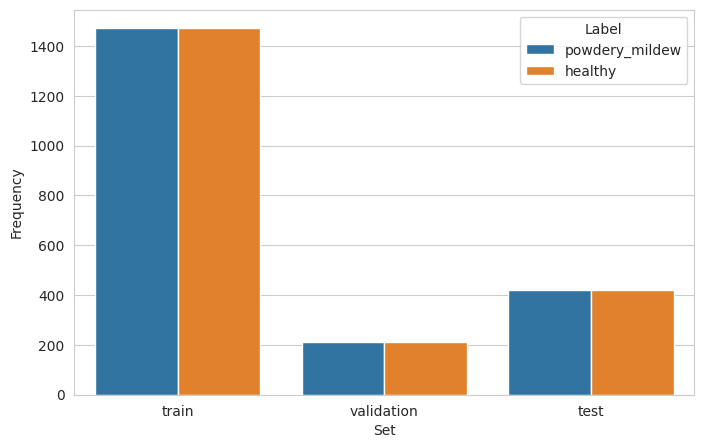

In [13]:
data = {
    'Set':[],
    'Label':[],
    'Frequency':[]
}

folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation 

Image Data Generator 

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [16]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [17]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [18]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented images

(20, 256, 256, 3)


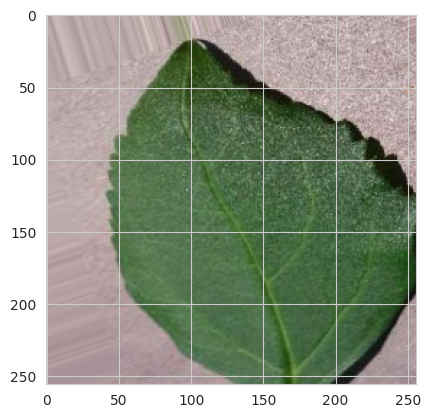

(20, 256, 256, 3)


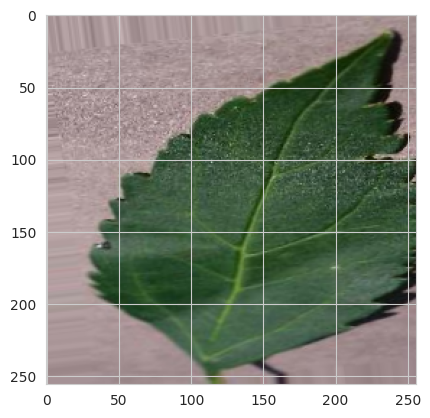

(20, 256, 256, 3)


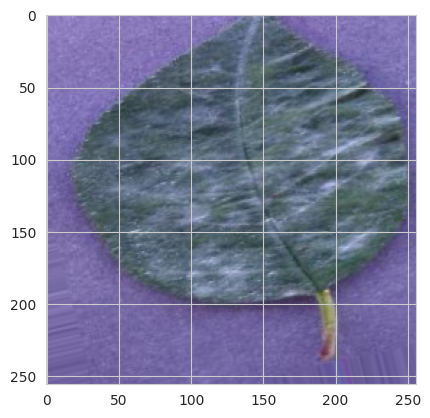

In [19]:
for _ in range (3):
    img, label = next(train_set)
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


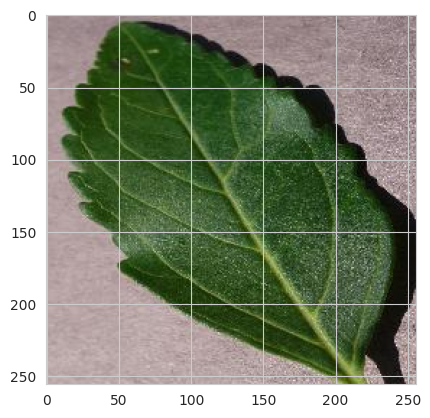

(20, 256, 256, 3)


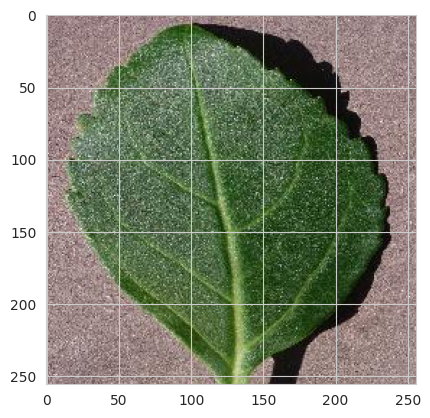

(20, 256, 256, 3)


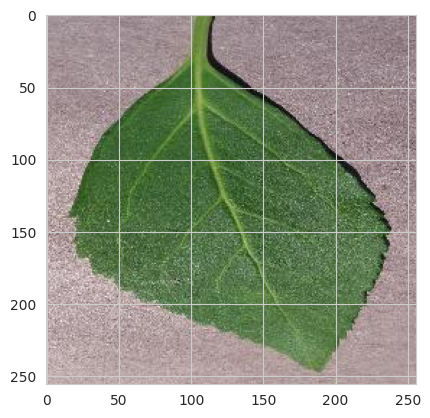

In [20]:
for _ in range (3):
    img, label = next(test_set)
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


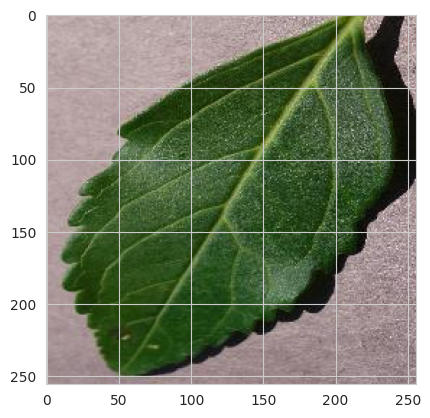

(20, 256, 256, 3)


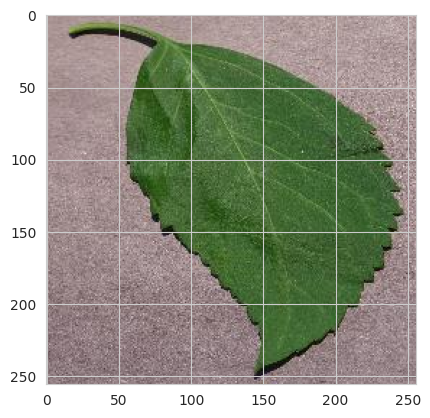

(20, 256, 256, 3)


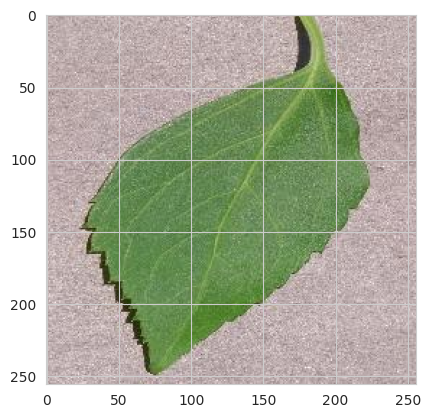

In [21]:
for _ in range (3):
    img, label = next(validation_set)
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

In [22]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

## Model creation 

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [24]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [25]:
create_tf_model().summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [28]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 121s 791ms/step - accuracy: 0.7216 - loss: 0.5948 - val_accuracy: 0.9571 - val_loss: 0.1834
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:43 706ms/step - accuracy: 0.9500 - loss: 0.0630

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9500 - loss: 0.0630 - val_accuracy: 0.9714 - val_loss: 0.1144
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 118s 801ms/step - accuracy: 0.9761 - loss: 0.0857 - val_accuracy: 0.9690 - val_loss: 0.1224
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 1.0000 - loss: 0.0244 - val_accuracy: 0.9833 - val_loss: 0.1061
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 146s 867ms/step - accuracy: 0.9884 - loss: 0.0499 - val_accuracy: 0.9976 - val_loss: 0.0138
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 1.0000 - loss: 0.0199 - val_accuracy: 0.9976 - val_loss: 0.0134
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 126s 796ms/step - accuracy: 0.9843 - loss: 0.0466 - val_accuracy: 0.9881 - val_loss: 0.0359
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.9905 - val_loss: 0.0322
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 123s 834ms/step - accuracy: 0.9918 - loss: 0.0351 - val_acc

### Save Model

In [29]:
model.save('outputs/v1/mildew_detector_model.h5')

## Model Performance Analysis

### Model Learning Curve

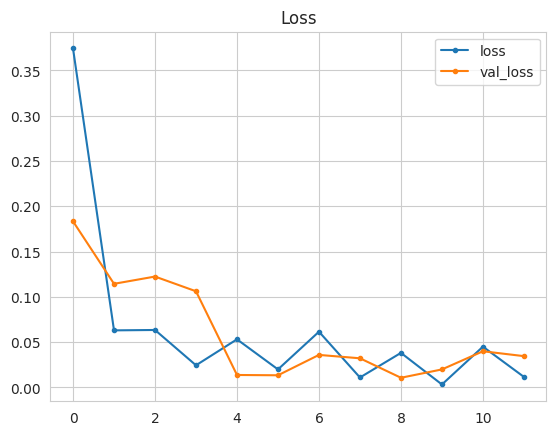

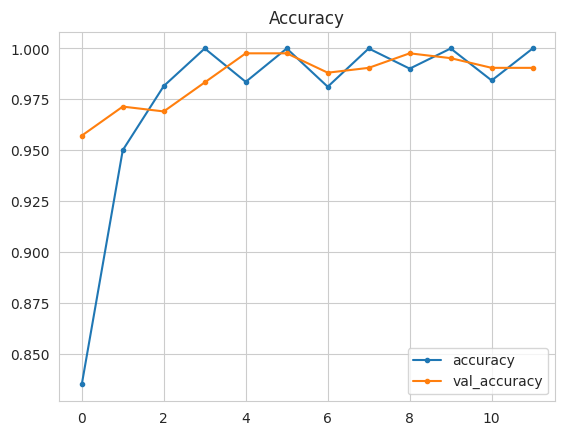

In [30]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [26]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)


IndentationError: expected an indented block after 'try' statement on line 2 (1114530593.py, line 5)